# Draft `pyGIMLi(emg3d)` - Inversion

**An attempt at using `pyGIMLi` as an inversion framework for `emg3d` computations.**

=> Create an environment using the provided `environment.yml`: `mamba env create`.

For developing purposes, we take a very simple model and survey:
- Simple double-halfspace model water-subsurface with a resistive block.
- Survey: A single 2D line, 7 sources, 7 frequencies.

**Current Limitations**
- Only isotropic models supported
- Only 'Conductivity' models supported
- Without el. perm. and magn. perm.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import emg3d
import pygimli as pg

## Load survey (incl. data), initial model, and create a Simulation

In [2]:
inp_data = emg3d.load('pginv-7x7.h5')        # Finer model (but still coarse)

inp_survey = inp_data['survey']
inp_model = inp_data['model']
inp_grid = inp_model.grid
inp_model

Data loaded from «/palmyra/data/dieterwerthmul/dev-pygimli-emg3d/pginv-7x7.h5»
[emg3d v1.8.4.dev11+g28220a0 (format 1.0) on 2024-07-10T15:14:12.205671].


Model: resistivity; isotropic; 142 x 62 x 24 (211,296)

In [3]:
# The model is resistivity. Change it to conductivity
# TODO: make this internally happen, so that pyGIMLi
# always gets a conductivity model!
con_model = emg3d.Model(inp_grid, 1/inp_model.property_x, mapping='Conductivity')
con_model

Model: conductivity; isotropic; 142 x 62 x 24 (211,296)

In [4]:
# For dev-purposes, we only select one source
# [for dev-purposes it is also a very simple model]
#inp_survey = inp_survey.select(sources='TxED-1')
inp_survey

:: Survey ::

<xarray.Dataset> Size: 47kB
Dimensions:   (src: 7, rec: 57, freq: 7)
Coordinates:
  * src       (src) <U6 168B 'TxED-1' 'TxED-2' 'TxED-3' ... 'TxED-6' 'TxED-7'
  * rec       (rec) <U7 2kB 'RxEP-01' 'RxEP-02' ... 'RxEP-56' 'RxEP-57'
  * freq      (freq) <U3 84B 'f-1' 'f-2' 'f-3' 'f-4' 'f-5' 'f-6' 'f-7'
Data variables:
    observed  (src, rec, freq) complex128 45kB (5.887967102900641e-08-2.44265...
Attributes:
    noise_floor:     1e-15
    relative_error:  0.03

## Create a Starting Model

In [5]:
hx = np.ones(58)*250.0
hy = np.ones(26)*250.0
hz = np.ones(15)*250.0
grid = emg3d.TensorMesh([hx, hy, hz], [-7250, -3250, -3500])

model = emg3d.Model(grid, 1.0, mapping='Conductivity')
model.property_x[:, :, -1:] = 3.33

# QC
grid

TensorMesh: 22,620 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     58     -7,250.00      7,250.00    250.00    250.00    1.00
   y     26     -3,250.00      3,250.00    250.00    250.00    1.00
   z     15     -3,500.00        250.00    250.00    250.00    1.00

## Create a Simulation

In [6]:
# Create an emg3d Simulation instance
sim = emg3d.simulations.Simulation(
    name='DevInv-7x7-reprNew-Iter30',
    survey=inp_survey,
    model=model,
    gridding='both',
    gridding_opts={'vector': 'xyz'},
    max_workers=50,
    receiver_interpolation='linear',
    ###solver_opts={'tol_gradient': 1e-4}, 
    tqdm_opts=False,
)
sim

:: Simulation «DevInv-7x7-reprNew-Iter30» ::

- Survey: 7 sources; 57 receivers; 7 frequencies
- Model: conductivity; isotropic; 58 x 26 x 15 (22,620)
- Gridding: Frequency- and source-dependent grids; 64 x 32 x 24 (49,152) - 80 x 40 x 32 (102,400)

## Instantiate and run inversion

In [7]:
markers = np.zeros(model.shape, dtype=int)
markers[:, :, grid.cell_centers_z > 0] = 1
fop = emg3d.inversion.pygimli.Kernel(simulation=sim, markers=markers)

INV = emg3d.inversion.pygimli.Inversion(fop=fop)
### INV.inv.setCGLSTolerance(10) 
INV.inv.setMaxCGLSIter(30)
### INV.dataTrans = pg.trans.TransSymLog(sim.survey.noise_floor)

INV.setRegularization(0, limits=(0.001, 2), startModel=1)
INV.setRegularization(1, limits=(3, 4), startModel=3.33) 

In [8]:
# DIFFERENT # fop.obs_resp_errors[fop.obs_resp_errors > 0.5] = 1e8
INV.run(
    # dataVals=fop.obs_resp_data,  # DIFFERENT # 
    # relativeError=fop.obs_resp_errors,  # DIFFERENT # 
    #maxIter=1, # just to test
    lam=1,
    #verbose=True,
    #startModel=...,
    #isReference=True,
)

17/07/24 - 14:24:46 - pyGIMLi - INFO - :: pyGIMLi(emg3d) START ::


17/07/24 - 14:24:46 - pyGIMLi - INFO - Created startmodel from region infos: 22620 [1.0,...,3.33]


17/07/24 - 14:25:10 - pyGIMLi - INFO - ======================================================================
                                        it        χ²   F(m)       λ        ϕᵈ        ϕᵐ    ϕ=ϕᵈ+λϕᵐ   Δϕ (%)
                                       ----------------------------------------------------------------------


17/07/24 - 14:25:10 - pyGIMLi - INFO -   0     183.1      1       1    774056         0      774056     0.00


17/07/24 - 15:02:01 - pyGIMLi - INFO -   1     171.7     65       1    725859      33.8      725893     6.22


17/07/24 - 15:37:04 - pyGIMLi - INFO -   2     154.3     65       1    652534     225.6      652760    10.07


17/07/24 - 16:13:09 - pyGIMLi - INFO -   3       129     65       1    545261     886.3      546147    16.33


17/07/24 - 16:49:09 - pyGIMLi - INFO -   4      85.1     65       1    359851    4177.3      364028    33.35


17/07/24 - 17:20:52 - pyGIMLi - INFO -   5      60.9     65       1    257596    6616.5      264213    27.42


17/07/24 - 17:51:30 - pyGIMLi - INFO -   6        37     65       1    156331   10853.4      167185    36.72


17/07/24 - 18:21:56 - pyGIMLi - INFO -   7      22.1     65       1   93387.2   13076.1      106463    36.32


17/07/24 - 18:53:00 - pyGIMLi - INFO -   8      19.4     66       1   81974.1   12204.9       94179    11.54


17/07/24 - 19:14:04 - pyGIMLi - INFO -   9      15.6     65       1   66149.8   12186.4     78336.2    16.82


17/07/24 - 19:29:54 - pyGIMLi - INFO -  10      15.1     66       1   63933.2     11764     75697.2     3.37


17/07/24 - 19:45:32 - pyGIMLi - INFO -  11      14.9     66       1   62794.1   11612.3     74406.4     1.71


17/07/24 - 19:45:33 - pyGIMLi - INFO - :: pyGIMLi(emg3d) END   :: runtime = 5:20:47


## Plots

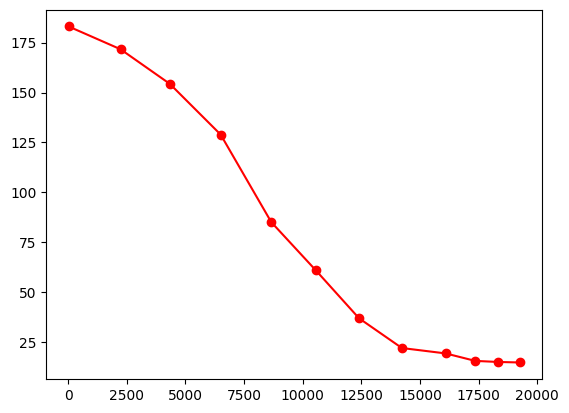

In [9]:
#invinfo = emg3d.load('DevInv-7x7-reprNew-Iter30.h5', verb=0)['invinfo']
invinfo = sim.invinfo
plt.figure()
plt.plot([it['time'] for it in invinfo.values()], [it['chi2'] for it in invinfo.values()], 'ro-')

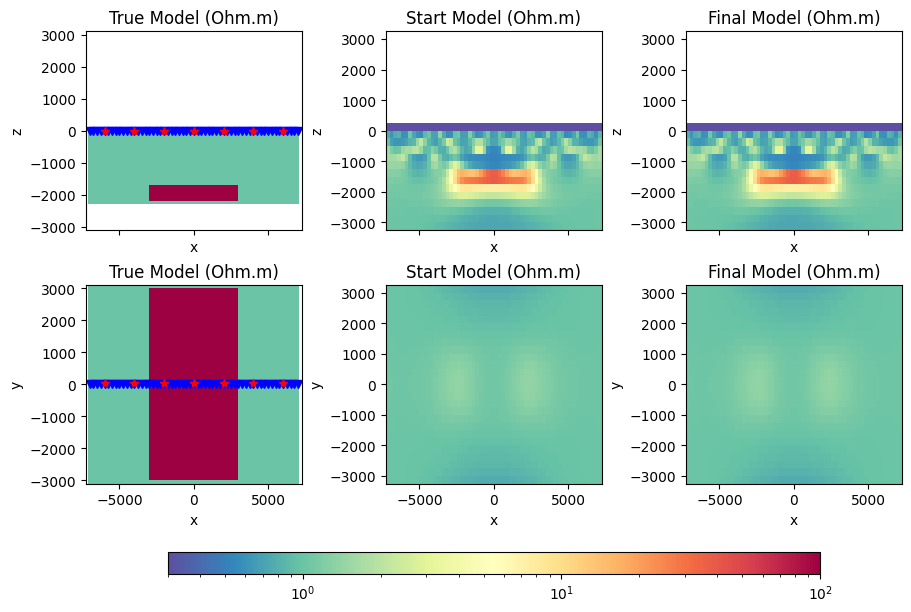

In [10]:
popts1 = {'cmap':'Spectral_r','norm':LogNorm(vmin=0.3, vmax=100)}
popts2 = {'edgecolors': 'grey', 'linewidth': 0.5, 'cmap':'Spectral_r','norm':LogNorm(vmin=0.3, vmax=100)}
opts = {'v_type': 'CC', 'normal': 'Y'}

rec_coords = sim.survey.receiver_coordinates()
src_coords = sim.survey.source_coordinates()

fig, axs = plt.subplots(2, 3, figsize=(9, 6), constrained_layout=True, sharex=True, sharey='col')
(ax1, ax2, ax3), (ax4, ax5, ax6) = axs

# True model
out1, = inp_grid.plot_slice(inp_data['true_model'].property_x.ravel('F'), ax=ax1, pcolor_opts=popts1, **opts)
ax1.set_title(f"True Model (Ohm.m)")
ax1.plot(rec_coords[0], rec_coords[1], 'bv')
ax1.plot(src_coords[0], src_coords[1], 'r*')

# Start model
out2, = model.grid.plot_slice(1/model.property_x.ravel('F'), ax=ax2, pcolor_opts=popts1, **opts)
ax2.set_title(f"Start Model (Ohm.m)")

# Final inversion model
out3, = model.grid.plot_slice(1/sim.model.property_x.ravel('F'), ax=ax3, pcolor_opts=popts1, **opts)
ax3.set_title(f"Final Model (Ohm.m)")

opts['normal'] = 'Z'
opts['ind'] = 4

# True model
out4, = inp_grid.plot_slice(inp_data['true_model'].property_x.ravel('F'), ax=ax4, pcolor_opts=popts1, **opts)
ax4.set_title(f"True Model (Ohm.m)")
ax4.plot(rec_coords[0], rec_coords[2], 'bv')
ax4.plot(src_coords[0], src_coords[2], 'r*')

# Start model
out5, = model.grid.plot_slice(1/model.property_x.ravel('F'), ax=ax5, pcolor_opts=popts1, **opts)
ax5.set_title(f"Start Model (Ohm.m)")

# Final inversion model
out6, = model.grid.plot_slice(1/sim.model.property_x.ravel('F'), ax=ax6, pcolor_opts=popts1, **opts)
ax6.set_title(f"Final Model (Ohm.m)")

plt.colorbar(out1, ax=axs, orientation='horizontal', fraction=.1, shrink=.8, aspect=30)
plt.savefig('ModelFit-7x7.png', dpi=300)

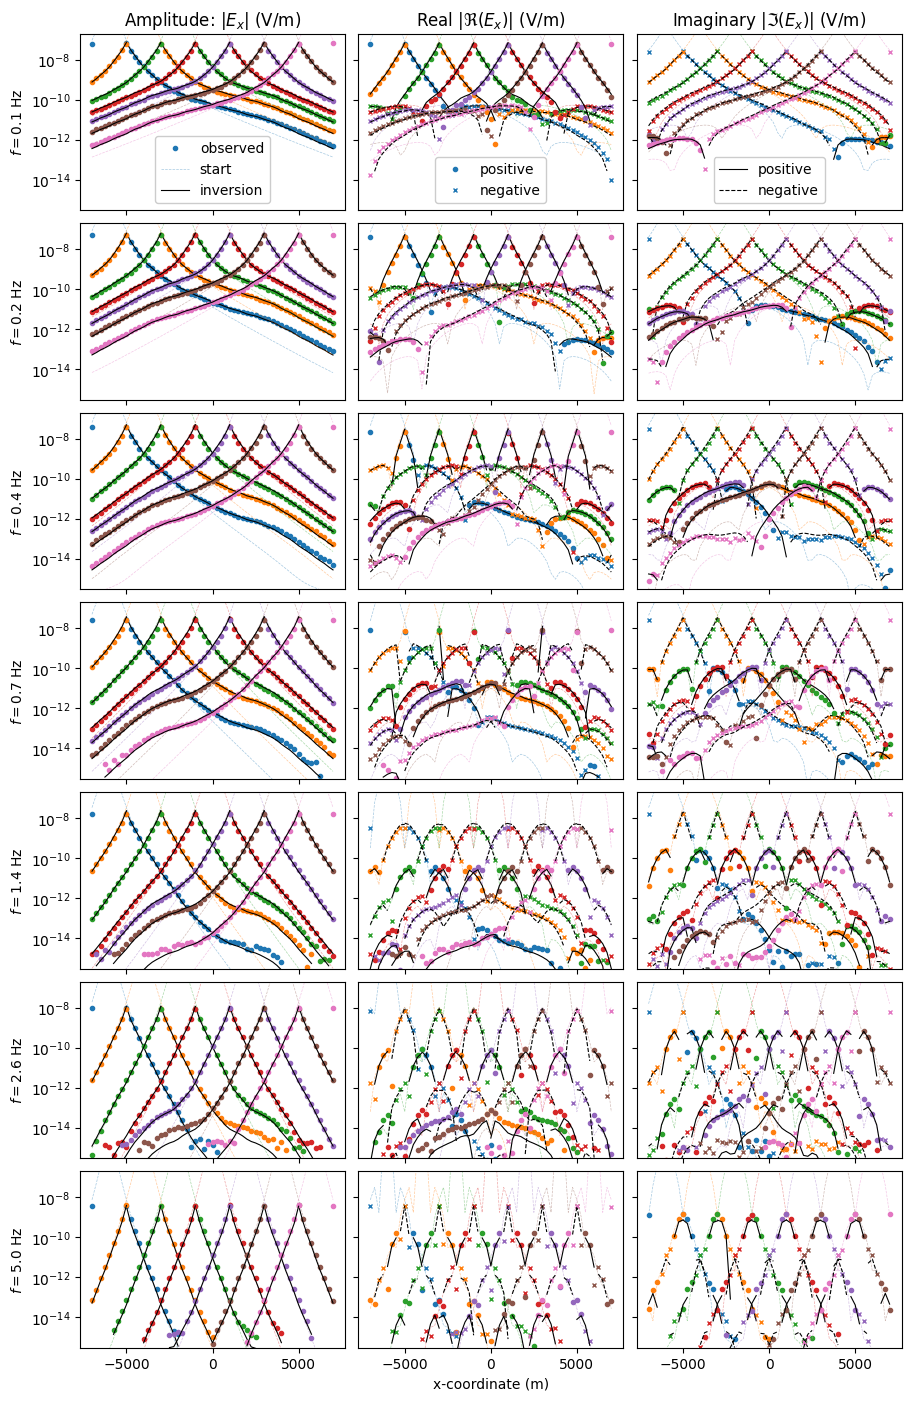

In [11]:
def pos(data):
    """Return positive data; set negative data to NaN."""
    return np.where(data > 0, data, np.nan)
    

height = sim.survey.shape[2]*1.7+2
fig, axs = plt.subplots(sim.survey.shape[2], 3, figsize=(9, height), constrained_layout=True, sharex=True, sharey=True)
axs = np.atleast_2d(axs)  # So it works if only 1 freq

# Data
obs_resp = sim.data.observed
inv_resp = sim.data.inv
start_resp = sim.data.it0

rec_coords = sim.survey.receiver_coordinates()

for ii, freq in enumerate(sim.survey.frequencies.keys()):
    for i, src in enumerate(sim.survey.sources.keys()):
        #if i in [1, 3, 5]:
        #    continue
        
        # obs_resperved data
        axs[ii, 0].plot(rec_coords[0], abs(obs_resp.loc[src, :, freq].data), f"C{i}.",
                        label='observed' if i == 0 else '')
        axs[ii, 1].plot(rec_coords[0], pos(obs_resp.loc[src, :, freq].data.real), f"C{i}.",
                        label='positive' if i == 0 else '')
        axs[ii, 1].plot(rec_coords[0], pos(-obs_resp.loc[src, :, freq].data.real), f"C{i}x", ms=3,
                        label='negative' if i == 0 else '')
        axs[ii, 2].plot(rec_coords[0], pos(obs_resp.loc[src, :, freq].data.imag), f"C{i}.")
        axs[ii, 2].plot(rec_coords[0], pos(-obs_resp.loc[src, :, freq].data.imag), f"C{i}x", ms=3)
        
        # Start model
        axs[ii, 0].plot(rec_coords[0], abs(start_resp.loc[src, :, freq].data), f"C{i}--", alpha=.4, lw=0.5,
                        label='start' if i == 0 else '')
        axs[ii, 1].plot(rec_coords[0], abs(start_resp.loc[src, :, freq].data.real), f"C{i}--", alpha=.4, lw=0.5)
        axs[ii, 2].plot(rec_coords[0], abs(start_resp.loc[src, :, freq].data.imag), f"C{i}--", alpha=.4, lw=0.5)
        
        # Inverted data
        axs[ii, 0].plot(rec_coords[0], abs(inv_resp.loc[src, :, freq].data), f"k-", lw=0.8,
                        label='inversion' if i == 0 else '')
        axs[ii, 1].plot(rec_coords[0], pos(inv_resp.loc[src, :, freq].data.real), f"k-", lw=0.8)
        axs[ii, 1].plot(rec_coords[0], pos(-inv_resp.loc[src, :, freq].data.real), f"k--", lw=0.8)
        axs[ii, 2].plot(rec_coords[0], pos(inv_resp.loc[src, :, freq].data.imag), f"k-", lw=0.8,
                        label='positive' if i == 0 else '')
        axs[ii, 2].plot(rec_coords[0], pos(-inv_resp.loc[src, :, freq].data.imag), f"k--", lw=0.8,
                        label='negative' if i == 0 else '')
        

    axs[ii, 0].set_ylabel(f'$f={sim.survey.frequencies[freq]}$ Hz')     

        
axs[0, 0].set_yscale('log')
axs[0, 0].set_ylim([3e-16, 2e-7])

axs[0, 0].set_title('Amplitude: $|E_x|$ (V/m)')
axs[0, 1].set_title('Real $|\Re(E_x)|$ (V/m)')
axs[0, 2].set_title('Imaginary $|\Im(E_x)|$ (V/m)')

axs[0, 0].legend(framealpha=1)
axs[0, 1].legend(framealpha=1)
axs[0, 2].legend(framealpha=1)

axs[-1, 1].set_xlabel('x-coordinate (m)')
# plt.savefig('ResponseFit-7x7.png', dpi=300)
plt.show()

In [12]:
emg3d.Report()

--------------------------------------------------------------------------------
  Date: Wed Jul 17 19:45:38 2024 CEST

                OS : Linux (Red Hat Enterprise Linux 8.10)
            CPU(s) : 128
           Machine : x86_64
      Architecture : 64bit
               RAM : 1006.8 GiB
       Environment : Jupyter
       File system : ext4

  Python 3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:36:13) [GCC
  12.3.0]

             numpy : 1.26.4
             scipy : 1.14.0
             numba : 0.58.1
             emg3d : 1.8.4.dev16+gcdca834
           empymod : 2.3.1
            xarray : 2024.6.0
        discretize : 0.10.0
              h5py : 3.11.0
        matplotlib : 3.8.4
              tqdm : 4.66.4
           IPython : 8.26.0
           pygimli : 1.5.1+50.g9fe93bdd
            pgcore : 1.5.0
--------------------------------------------------------------------------------